In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy.integrate import quad

import lilguys as lguys
from lilguys import units as lu
import arya
from glob import glob as glob


In [3]:
def get_Vc(snap, r):
    n = np.sum(snap.r < r)
    vs =  np.sqrt(n * snap.m/r) 
    return vs * lu.V_0

In [4]:
def get_most_bound(snap, knn=10):
    #X_tree = KDTree(snap.pos)
    #k_d, k_i = X_tree.query(snap.pos, k=knn)
    idx = np.argmin(snap.potential)
    return snap.pos[idx], snap.vel[idx]

In [5]:
def get_Vmax(snap, rs=np.linspace(0.25, 10, 100)):
    vs = [get_Vc(snap, r) for r in rs]
    idx_max = np.argmax(vs)
    return vs[idx_max], rs[idx_max]

In [28]:
out = lguys.Output("../mw_models/orbits/out")

In [29]:
pos_f = out.pos[-1, :, :]

(-300.0, 300.0)

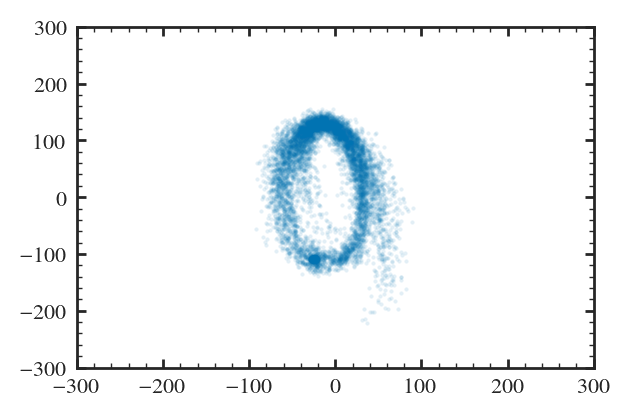

In [30]:
plt.scatter(pos_f[:, 0], pos_f[:, 1], s=0.3, alpha=0.1)
plt.xlim(-300, 300)
plt.ylim(-300, 300)

In [31]:
np.log10(lu.M_0)

10.0

In [34]:
snap_xs = np.empty((out.Nt, 3))
v_disp = np.empty((out.Nt))
rs = np.empty(out.Nt)
Rs = 2

for i in range(out.Nt):
    snap = out[i]
    # p0 = np.mean(snap.pos, axis=0)
    # v0 = np.mean(snap.vel, axis=0)
    p0, v0 = lguys.profile.get_most_bound(snap)
    snap = snap.shift(-p0, -v0)
    snap_xs[i] = p0
    #filt = np.isin(IDs, ID_stars)
    v_disp[i], rs[i] = get_Vmax(snap)

In [ ]:
plt.scatter(np.arange(out.Nt), v_disp)
plt.xlabel("snapshot")
plt.ylabel(r"$V_{\rm circ}$")
plt.savefig("vcirc.pdf")

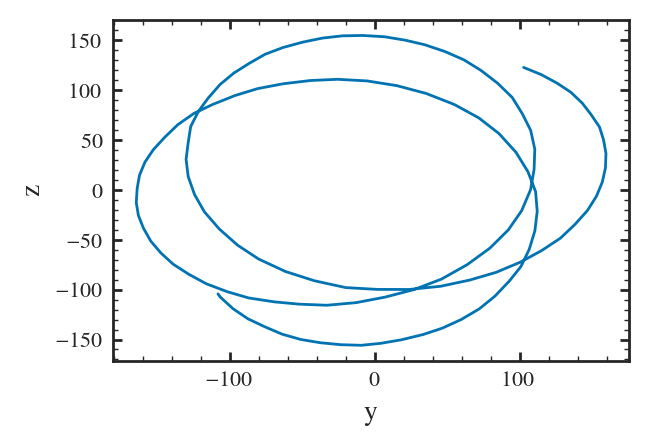

In [97]:
plt.plot(snap_xs[:, 1], snap_xs[:, 2])
plt.xlabel("y")
plt.ylabel("z")
plt.savefig("center_orbit.pdf")

In [37]:
import matplotlib.animation

In [38]:
snap0 = out[0]

MovieWriter ffmpeg unavailable; using Pillow instead.


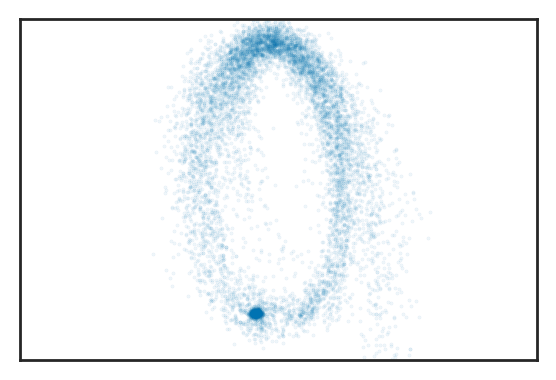

In [96]:
fig = plt.figure()

scat = plt.scatter(snap0.x, snap0.y, s=0.1, alpha=0.1)

plt.xlim(-180, 160)
plt.ylim(-150, 150)
plt.xticks([])
plt.yticks([])
    
def update_fig(i, scat):
    X = out.pos[i, :, 0:2]
    # snap = lguys.profile.center_snapshot(snap)
    scat.set_offsets(X)
    return scat, 
    
ani = mpl.animation.FuncAnimation(fig, update_fig, frames=range(out.Nt),
                                  fargs=(scat,))

ani.save("orbit.gif", dpi=200)
plt.show()

In [41]:
snap_i = out[1]
snap_f = out[-1]

In [90]:
def get_mid_coord(snap):
    p0, v0 = lguys.profile.get_most_bound(snap)
    phase = lguys.coords.phase_point(*p0, *v0)
    return lguys.coords.to_sky(phase)

In [91]:
mid_obs = get_mid_coord(snap_i)

In [92]:
obs = lguys.coords.to_sky(snap_i)

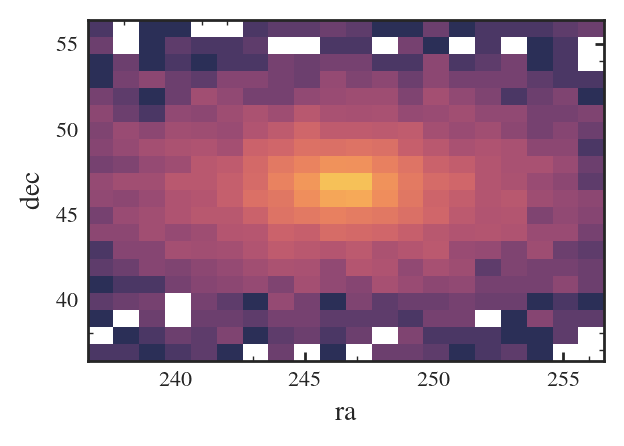

In [94]:
d_deg = 10
ra_0 = mid_obs.ra
dec_0 = mid_obs.dec

plt.hist2d(obs.ra, obs.dec, 20,norm=mpl.colors.LogNorm(1, 1e3),
          range=((ra_0-d_deg, ra_0+d_deg), (dec_0-d_deg, dec_0+d_deg)));
plt.xlabel("ra")
plt.ylabel("dec")
plt.savefig("skyproj_init.pdf")

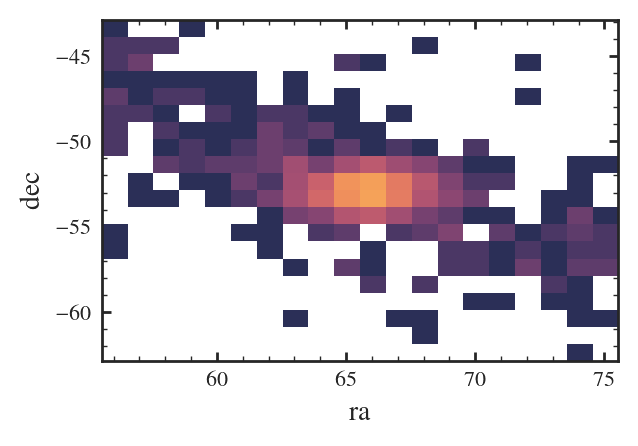

In [95]:
mid_obs = get_mid_coord(snap_f)
obs = lguys.coords.to_sky(snap_f)
d_deg = 10
ra_0 = mid_obs.ra
dec_0 = mid_obs.dec

plt.hist2d(obs.ra, obs.dec, 20,norm=mpl.colors.LogNorm(1, 1e3),
           range=((ra_0-d_deg, ra_0+d_deg), (dec_0-d_deg, dec_0+d_deg)));
plt.xlabel("ra")
plt.ylabel("dec")
plt.savefig("skyproj_fin.pdf")

# Calculate stellar probabilities

In [55]:
from lilguys import profile

In [59]:
snap0 = snap_i

In [60]:
G = 1
EPSREL = 1e-7

# profile scale radius and index
n = 1
rsS = 2 # kpc, input

EN = 20
DF_Nr = 20

In [61]:
snap0 = lguys.profile.center_snapshot(snap0)

r = snap0.r

idx_sort = np.argsort(r)

m = snap0.m
N = len(r)
Mr = m * np.arange(N)

N = len(r)
Φ = snap0.potential
IDs = snap0.IDs
# Phi = -G * (Mr/r[idx_sort] + np.cumsum(m / r[idx_sort][::-1])[::-1])

shifting by [ 28.0181  114.61614 115.67326], [-0.22731042  0.48120338 -0.38250676]


In [62]:
E_kin = 1/2 * np.sum(snap0.vel**2, axis=1)
E_kin = np.array(E_kin)
Etot = E_kin + Φ[np.argsort(idx_sort)]

In [63]:
def ρ_star(r):
    return np.exp(-(r/rsS)**(1/n))

def ρ_s_int(r):
    return 4*np.pi * r**2 * ρ_star(r)

M_star = quad(ρ_s_int, 0., np.inf)[0]
M_star_r = np.vectorize(lambda x: quad(ρ_s_int, 0, x)[0])

In [64]:
DF_r_max = np.max(r)
DF_r_min = np.min(r[r > 2*EPSREL])
bins = np.logspace(np.log10(DF_r_min), np.log10(DF_r_max), num=DF_Nr)
DFr = 1/2 * (bins[1:] + bins[:-1])

In [65]:
NinS = quad(ρ_s_int, 0, DF_r_min)[0]  / M_star

NoutS = 1 - quad(ρ_s_int, 0, DF_r_max)[0]/M_star

In [66]:
prof = lguys.profile.Profile(snap_i)

shifting by [ 28.0181  114.61614 115.67326], [-0.22731042  0.48120338 -0.38250676]


In [67]:
prof_f = lguys.profile.Profile(snap_f)

shifting by [ -24.595531 -108.37018  -104.245605], [ 0.20275888 -0.37115845  0.6964236 ]


/tmp/ipykernel_11560/1673689236.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(prof.r), np.log10(prof.nu_DM), label="initial")


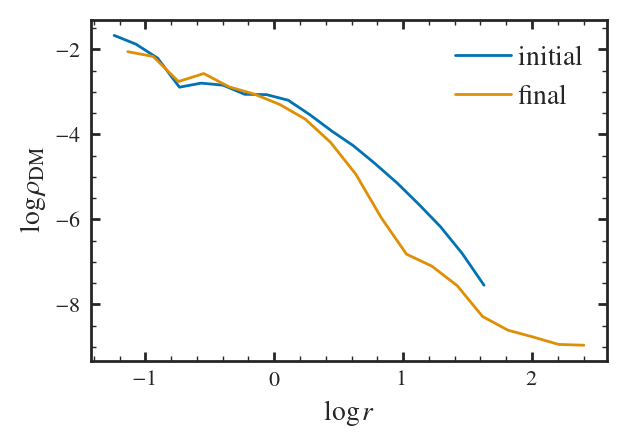

In [68]:
plt.plot(np.log10(prof.r), np.log10(prof.nu_DM), label="initial")

plt.plot(np.log10(prof_f.r), np.log10(prof_f.nu_DM), label="final")
plt.xlabel(r"$\log r$")
plt.ylabel(r"$\log \rho_{\rm DM}$")

plt.legend()
plt.savefig("dm_density.pdf")

In [69]:
psi = - np.interp(DFr, r[idx_sort], Φ)

nuDM, edges = np.histogram(r, bins=bins)
dV = (4/3 * np.pi * (edges[1:]**3 - edges[:-1]**3))
nuDM = nuDM * m / dV

DF_rm = 1/2*(edges[1:] + edges[:-1])

In [70]:
nuS = ρ_star(DF_rm) / M_star

In [71]:
M_cum = np.interp(DF_rm, r[idx_sort], Mr)
M_star_cum = M_star_r(DF_rm)

In [72]:
M_star_cum

array([2.41452047e-04, 7.69598787e-04, 2.44498042e-03, 7.73020765e-03,
       2.42673794e-02, 7.53910479e-02, 2.30652976e-01, 6.89997488e-01,
       1.99759441e+00, 5.51473795e+00, 1.42192855e+01, 3.32871690e+01,
       6.82351266e+01, 1.17658581e+02, 1.65722912e+02, 1.93081218e+02,
       2.00378352e+02, 2.01048358e+02, 2.01061899e+02])

/tmp/ipykernel_11560/1652554652.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(DF_rm), np.log10(nuDM), label="DM")


Text(0, 0.5, '$\\log_{10} \\nu$')

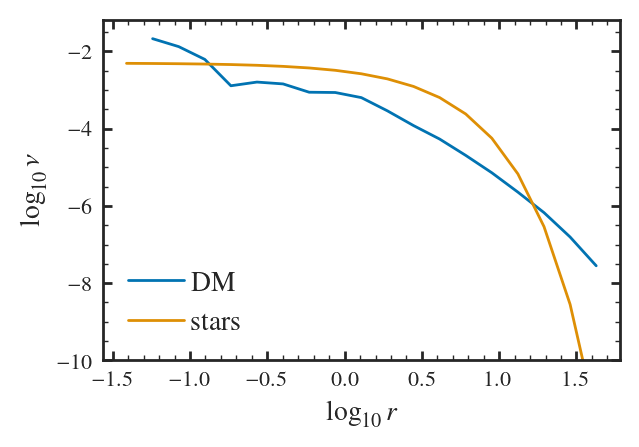

In [73]:
plt.plot(np.log10(DF_rm), np.log10(nuDM), label="DM")
plt.plot(np.log10(DF_rm), np.log10(nuS), label="stars")
plt.legend()
plt.ylim(-10)
plt.xlabel(r"$\log_{10} r$")
plt.ylabel(r"$\log_{10} \nu$")

Text(0.5, 0, '$\\log r$')

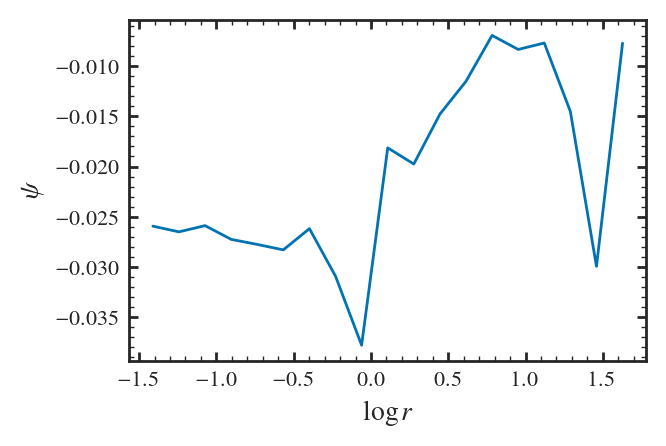

In [74]:
plt.plot(np.log10(DF_rm), -psi)
plt.ylabel(r"$\psi$")
plt.xlabel(r"$\log r$")

In [75]:
dndpDM   = np.gradient(nuDM,   psi)
d2nd2pDM = np.gradient(dndpDM, psi)
dndpS   = np.gradient(nuS,   psi)
d2nd2pS = np.gradient(dndpS, psi)

In [76]:
fS  = np.vectorize( lambda e: 1./(np.sqrt(8)*np.pi**2) * (quad( lambda p:  np.interp(p, psi[::-1], d2nd2pS[::-1]) / np.sqrt(e-p) , 0., e,  epsrel=EPSREL)[0]  ) ) # + np.interp(0., psi, dndp) / np.sqrt(
fDM = np.vectorize( lambda e: 1./(np.sqrt(8)*np.pi**2) * (quad( lambda p:  np.interp(p, psi[::-1], d2nd2pDM[::-1]) / np.sqrt(e-p) , 0., e,  epsrel=EPSREL)[0]  ) )


In [77]:
E_max = psi[0]
E_min = E_max / EN

In [78]:
E = np.linspace(E_min, E_max, EN)

In [79]:
DF_stars = fS(E)

In [80]:
DF_DM = fDM(E)

/tmp/ipykernel_11560/60630724.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(-E, np.log10(DF_DM))
/tmp/ipykernel_11560/60630724.py:3: RuntimeWarning: invalid value encountered in log10
  plt.plot(-E, np.log10(DF_stars))


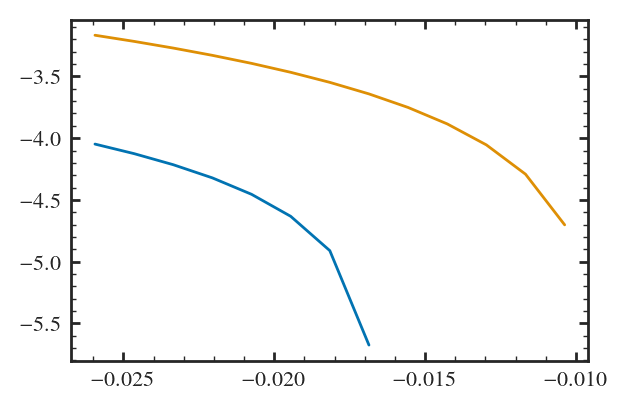

In [81]:
# plot DF vs -E
plt.plot(-E, np.log10(DF_DM))
plt.plot(-E, np.log10(DF_stars))

In [82]:
probs = np.interp(-Etot, E, DF_stars) / np.interp(-Etot, E, DF_DM)

In [83]:
probs /= np.sum(probs)

In [84]:
nuS_Nbody, edges = np.histogram(r, weights=probs, bins=bins)
nuS_Nbody = nuS_Nbody / dV

/tmp/ipykernel_11560/1322621873.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(DF_rm), np.log10(nuS_Nbody))
/tmp/ipykernel_11560/1322621873.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(DF_rm), np.log10(nuS_Nbody))


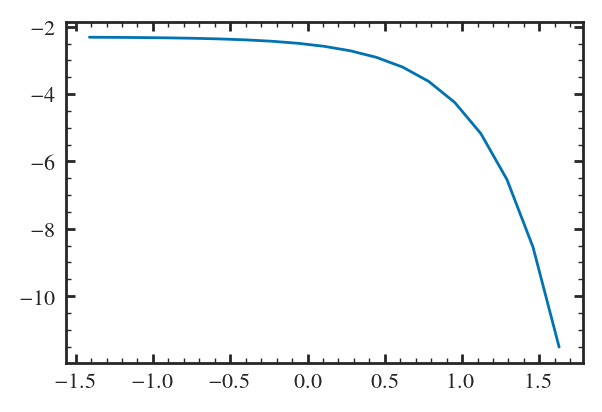

In [85]:
plt.plot(np.log10(DF_rm), np.log10(nuS))
plt.plot(np.log10(DF_rm), np.log10(nuS_Nbody))

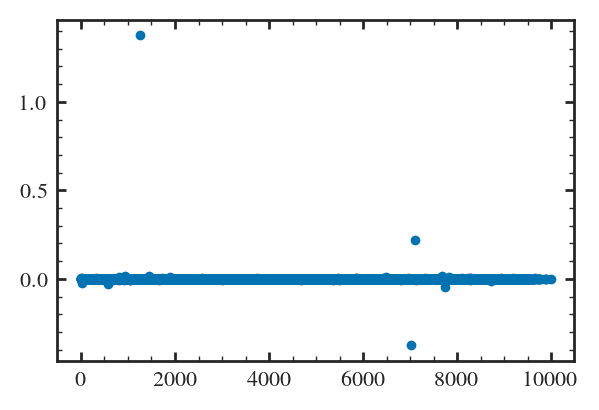

In [86]:
plt.scatter(IDs, probs)

In [87]:
Ns = 100

ID_stars = IDs[probs*Ns > np.random.uniform(size=N)]

In [88]:
ID_stars

array([3718, 1439, 7673, 5797, 7702, 7171, 8286, 5814, 7539, 8327, 8075,
       7773, 6418, 5464, 7110, 7009, 7814, 6271, 9181, 6133, 6785, 7836,
       8100, 6482, 8220, 8413, 7371, 7603, 1255, 1123,  324, 1137, 3750,
        486, 2803, 2594, 1468, 1229,  806, 1893,  946, 1516, 6945, 8688,
       7827], dtype=uint32)